# CNN Classifier for Plant Waves Using Recurrence Plots
----

#### PREPROCESSING: Create Recurrence Plot Images 
In this step, we compute the recurrence plots, create recurrence plot images, reshape it to 97x97 images, and store them to disk with labels corresponding to classes and the number of sample. 

In [ ]:
import numpy as np
import torch
import pickle
import os
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from scipy import signal
from PIL import Image
from tqdm import tqdm

%run ../src/utils/constants.py

Load raw data that has been split into train, test, and validation sets for the 81k and 191k cases.

In [ ]:
path_to_pickle_train81k = DATASETS_DIR / "train-81k-stratified-without-neutral.pkl"
path_to_pickle_train191k = DATASETS_DIR / "train-191k-stratified-without-neutral.pkl"
path_to_pickle_test81k = DATASETS_DIR / "test-81k-stratified-without-neutral.pkl"
path_to_pickle_val81k = DATASETS_DIR / "val-81k-stratified-without-neutral.pkl"

In [ ]:
with open(path_to_pickle_train81k, 'rb') as train_81k_file:
    train_81k = pickle.load(train_81k_file)

In [ ]:
with open(path_to_pickle_train191k, 'rb') as train_191k_file:
    train_191k = pickle.load(train_191k_file)

In [ ]:
with open(path_to_pickle_test81k, 'rb') as test_81k_file:
    test_81k = pickle.load(test_81k_file)

In [ ]:
with open(path_to_pickle_val81k, 'rb') as val_81k_file:
    val_81k = pickle.load(val_81k_file)

While ignoring the class `Neutral`, separate wave slices and labels, and create a Tensor dataset. Adjust `for segment in train_191k` for creating a specific dataset - train, test, val. Downsample the signal wave for faster computation of the recurrence plots. Downsample factor is `10`. 

In [ ]:
wav_slices = []
labels = []
downsample_factor = 10
for segment in val_81k:  # adjust this iterable for specific dataset.
    downsampled_wav_slice = segment[0][::downsample_factor]
    wav_slices.append(downsampled_wav_slice)
    labels.append(segment[1])

In [ ]:
print(wav_slices[0].shape)

In [ ]:
wav_slices = torch.tensor(np.array(wav_slices), dtype=torch.float32)
labels = torch.tensor(np.array(labels), dtype=torch.long)
dataset = TensorDataset(wav_slices, labels)
print(wav_slices)

Normalize the samples using per-sample normalization.

In [ ]:
data_tensor, labels_tensor = dataset.tensors
mean = torch.mean(data_tensor, dim=1, keepdim=True)
std_dev = torch.std(data_tensor, dim=1, keepdim=True)
standardized_data = (data_tensor - mean) / (std_dev + 0.00000001)  # smoothing term to prevent zero division

dataset = TensorDataset(standardized_data, labels_tensor)

Compute the spectrograms and save the plots to disk as `.png`. 

In [ ]:
train_81k_folder = "train-81k"
train_191k_folder = "train-191k"  # for now, ignore this case.
test_81k_folder = "test-81k"
val_81k_folder = "val-81k"

In [ ]:
if not os.path.exists(RECURRENCEPLOT_IMAGE_DIR / train_81k_folder):
    os.makedirs(RECURRENCEPLOT_IMAGE_DIR / train_81k_folder)

if not os.path.exists(RECURRENCEPLOT_IMAGE_DIR / test_81k_folder):
    os.makedirs(RECURRENCEPLOT_IMAGE_DIR / test_81k_folder)

if not os.path.exists(RECURRENCEPLOT_IMAGE_DIR / val_81k_folder):
    os.makedirs(RECURRENCEPLOT_IMAGE_DIR / val_81k_folder)

Compute the recurrence plot by (1) determining element-wise differences between values of the time series, looking at the absolute values, and (2) by creating a binary matrix subject to a threshold. 

In [ ]:
def recurrence_plot(time_series, threshold=0.1):
    distance_matrix = np.abs(np.subtract.outer(time_series, time_series))  # element-wise differences
    recurrence_matrix = (distance_matrix < threshold).astype(int)  # binary

    return recurrence_matrix

Adjust the `train_81k_folder` to save the created recurrence plots.

In [ ]:
count = 0 
for wav_slice, label in tqdm(dataset):
    rec_matrix = recurrence_plot(wav_slice, threshold=0.15)

    file_name = f"{count}_mfcc_class_{label}.png"
    save_path = os.path.join(RECURRENCEPLOT_IMAGE_DIR / val_81k_folder, file_name)  # Adjust train_191k_folder

    if not os.path.exists(save_path):
        plt.imshow(rec_matrix, cmap='binary_r', interpolation='none')
        plt.axis("off")
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    
    count += 1

----
#### PREPROCESSING: LOAD Recurrence Plot Images
Prepare the train data for the CNN.

In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

%run ../src/utils/constants.py

In [2]:
train_81k_folder = "train-81k"
#train_191k_folder = "train-191k"

In [10]:
# Load all Recurrence Plot images and file names. 
images_train = []
labels_train = []

image_filenames = os.listdir(RECURRENCEPLOT_IMAGE_DIR / train_81k_folder)
image_paths = [os.path.join(RECURRENCEPLOT_IMAGE_DIR / train_81k_folder, filename) for filename in image_filenames]

IMAGE_SIZE = (97,97)
N_CHANNELS = 1  # grey
for path in tqdm(image_paths): 
    file_name = os.path.basename(path)
    label_train = int(file_name.split(".")[0].split("_")[-1])    
    img = Image.open(path).convert("L")  # greyscale
    img = img.resize(IMAGE_SIZE)
    img_array = np.array(img) / 255.0
    images_train.append(img_array)
    labels_train.append(label_train)

100%|███████████████████████████████████| 12130/12130 [00:24<00:00, 489.43it/s]


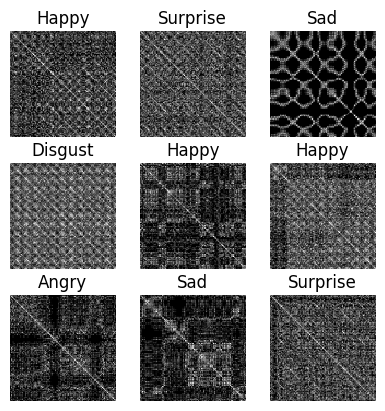

In [12]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_train[i], cmap='binary_r', interpolation='none')
    plt.title(f"{map_int_to_label(labels_train[i])}")  
    plt.axis("off")
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=-0.45)
plt.show()

In [15]:
val_81k_folder = "val-81k"

In [16]:
# Load all Recurrence Plot images and file names. 
images_val = []
labels_val = []

image_filenames_val = os.listdir(RECURRENCEPLOT_IMAGE_DIR / val_81k_folder)
image_paths_val = [os.path.join(RECURRENCEPLOT_IMAGE_DIR / val_81k_folder, filename_val) for filename_val in image_filenames_val]

IMAGE_SIZE = (97,97)
N_CHANNELS = 1  # grey
for path_val in tqdm(image_paths_val): 
    file_name_val = os.path.basename(path_val)
    label_val = int(file_name_val.split(".")[0].split("_")[-1])    
    img_val = Image.open(path_val).convert("L")  # convert to greyscale
    img_val = img_val.resize(IMAGE_SIZE)
    img_array_val = np.array(img_val) / 255.0
    images_val.append(img_array_val)
    labels_val.append(label_val)

100%|█████████████████████████████████████| 2600/2600 [00:15<00:00, 170.03it/s]


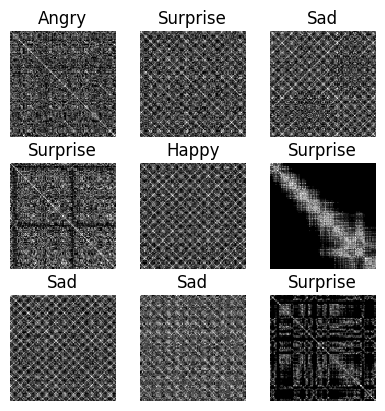

In [19]:
# plots inspired by https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_val[i], cmap='binary_r', interpolation='none')
    plt.title(f"{map_int_to_label(labels_val[i])}")  
    plt.axis("off")
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=-0.45)

plt.show()

Create datasets and dataloaders.

In [21]:
images_train = torch.tensor(np.array(images_train), dtype=torch.float32)
images_train = images_train.unsqueeze(1)
labels_train = torch.tensor(np.array(labels_train), dtype=torch.long)
train81k_dataset = TensorDataset(images_train, labels_train)

images_val = torch.tensor(np.array(images_val), dtype=torch.float32)
images_val = images_val.unsqueeze(1)
labels_val = torch.tensor(np.array(labels_val), dtype=torch.long)
val81k_dataset = TensorDataset(images_val, labels_val)

In [22]:
batch_size = 32
train81k_loader = DataLoader(train81k_dataset, batch_size)
val81k_loader = DataLoader(val81k_dataset, batch_size)

#### Hyperparameter Optimization
Specify a study name and define the search space for the grid search. 

Run `PREPROCESSING: LOAD Recurrence Plot Images`.

In [24]:
import torch
import wandb
import math
import optuna
from optuna.trial import TrialState
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score

Define the CNN model. Compute the hidden dimension of the transformed image successively. Images dimension are manipulated as follows:

1. Convolution layer: `output_dim` = `input_dim` - `filter_size` + `1`
2. Maxpool layer: `floor`((`input_dim`-`kernel_size`) / `stride`) + `1`

whereby the output dimension refers to either image height or image length. 

In [25]:
def define_model(trial):
    layers = []

    N_CLASSES = 6
    conv_kernel_size = trial.suggest_categorical(f"conv_kernel_size", [3, 5, 7])
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.0, 0.1, 0.2])

    input_channels = 1
    out_channels_l1 = trial.suggest_categorical(f"out_channels_l1", [2 ** i for i in range(4, 8)])
    
    layers.append(torch.nn.Conv2d(input_channels, out_channels_l1, kernel_size=conv_kernel_size))
    hidden_img_height = IMAGE_SIZE[0] - conv_kernel_size + 1
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
    hidden_img_height = math.floor((hidden_img_height - 2) / 2) + 1
    layers.append(torch.nn.Dropout(dropout_rate))

    out_channels_l2 = trial.suggest_categorical(f"out_channels_l2", [2 ** i for i in range(4, 7)])

    layers.append(torch.nn.Conv2d(out_channels_l1, out_channels_l2, kernel_size=conv_kernel_size))
    hidden_img_height = hidden_img_height - conv_kernel_size + 1
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
    hidden_img_height = math.floor((hidden_img_height - 2) / 2) + 1
    layers.append(torch.nn.Dropout(dropout_rate))

    layers.append(torch.nn.Flatten())

    layers.append(torch.nn.Linear(out_channels_l2 * hidden_img_height * hidden_img_height, 64))  # Likely wrong...
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(64, N_CLASSES))

    config_dict = {
        "out_channels_l1": out_channels_l1,
        "out_channels_l2": out_channels_l2,
        "conv_kernel_size": conv_kernel_size,
        "dropout_rate": dropout_rate
    }

    return torch.nn.Sequential(*layers), config_dict

Define the objective function for optuna for the hyperparameter optimization.

In [26]:
def objective(trial): 
    model, config_dict = define_model(trial)

    lr = trial.suggest_categorical('lr', [0.0001, 0.001, 0.01])

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print(config_dict)
    name_experiment = (f"{trial.number}_{NAME_CORE}_lr-{lr}_convf1-{config_dict['out_channels_l1']}_convf2-"
                       f"{config_dict['out_channels_l2']}_convker-{config_dict['conv_kernel_size']}_dr-{config_dict['dropout_rate']}")

    config_dict["lr"] = lr
    config_dict["epochs"] = NUM_EPOCHS

    wandb.init(
        project="model_" + NAME_CORE + "-hpo",
        dir=LOGS_DIR,
        name=name_experiment,
        config=config_dict
    )


    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_data, batch_labels in tqdm(train81k_loader):          
            # zero gradients
            optimizer.zero_grad()

            # forward + backward pass
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        all_preds = []
        all_labels = []

        model.eval()
        with torch.no_grad():
            for batch_data, batch_labels in tqdm(val81k_loader): 
                output = model(batch_data)

                predicted = output.argmax(dim=1)
                all_preds.extend(predicted.numpy())
                all_labels.extend(batch_labels.numpy())

        # TODO: explicitely state in written thesis that zero_division=0.0
        balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
        accuracy = accuracy_score(all_labels, all_preds)
        f1_class = f1_score(all_labels, all_preds, average=None, zero_division=0.0)
        f1_weighted = f1_score(all_labels, all_preds, average="weighted", zero_division=0.0)
        recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0.0)
        precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0.0)

        trial.report(balanced_accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

            
        metrics = {
            "balanced_accuracy": balanced_accuracy,
            "accuracy": accuracy,
            "f1_weighted": f1_weighted,
            "recall": recall,
            "precision": precision
        }

        wandb_input = metrics
        wandb.log(wandb_input)

    wandb.finish()

    return balanced_accuracy

Run hyperparameter optimization using optuna. 

In [30]:
NAME_CORE = "cnn_recplot_6_grey_81k_searchspace_324"
NUM_EPOCHS = 20

In [31]:
search_space = {
    'lr': [0.0001, 0.001, 0.01],
    'out_channels_l1': [2 ** i for i in range(4, 8)],   # 4 values
    'out_channels_l2': [2 ** i for i in range(4, 7)],   # 3 values
    'conv_kernel_size': [3, 5, 7],
    "dropout_rate": [0.0, 0.1, 0.2]
}

In [32]:
num_combi = 1
for i in search_space:
    num_combi *= len(search_space[i])
num_combi

324

In [ ]:
sampler = optuna.samplers.GridSampler(search_space)
study = optuna.create_study(sampler=sampler, study_name=NAME_CORE, storage="sqlite:///hpo_" + NAME_CORE + ".db",
                            direction="maximize", load_if_exists=True)
study.optimize(objective, n_trials=num_combi)

[I 2024-01-07 20:57:27,777] A new study created in RDB with name: cnn_recplot_6_grey_81k_searchspace_324


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


wandb: Currently logged in as: totikos. Use `wandb login --relogin` to force relogin


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.04it/s]


accuracy,▁▁▄▆▇▇▇▇▇███████████
balanced_accuracy,▁▁▄▅▇▇█▇████████████
f1_weighted,▁▁▄▆▇███████████████
precision,▁▃▅▆▇▇▇▇▇███████████
recall,▁▁▄▆▇▇▇▇▇███████████
accuracy,0.46269
balanced_accuracy,0.30442
f1_weighted,0.42272
precision,0.44482
recall,0.46269


[I 2024-01-07 21:41:16,080] Trial 0 finished with value: 0.3044200331085032 and parameters: {'conv_kernel_size': 7, 'dropout_rate': 0.2, 'out_channels_l1': 16, 'out_channels_l2': 64, 'lr': 0.0001}. Best is trial 0 with value: 0.3044200331085032.


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  4.95it/s]


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
balanced_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_weighted,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.31731
balanced_accuracy,0.16667
f1_weighted,0.15286
precision,0.10068
recall,0.31731


[I 2024-01-07 23:04:00,282] Trial 1 finished with value: 0.16666666666666666 and parameters: {'conv_kernel_size': 7, 'dropout_rate': 0.1, 'out_channels_l1': 64, 'out_channels_l2': 32, 'lr': 0.01}. Best is trial 0 with value: 0.3044200331085032.


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.94it/s]


accuracy,▁▂▃▅▅▆▆▇▇▇▇▇▇▇██████
balanced_accuracy,▁▂▃▅▆▆▇▇▇▇▇▇▇▇██████
f1_weighted,▁▄▄▅▆▆▇▇▇▇▇▇████████
precision,▁▃▇▇▇▇▇▇▇▇▇█████████
recall,▁▂▃▅▅▆▆▇▇▇▇▇▇▇██████
accuracy,0.46077
balanced_accuracy,0.30503
f1_weighted,0.42355
precision,0.4329
recall,0.46077


[I 2024-01-07 23:29:01,419] Trial 2 finished with value: 0.30502772583444604 and parameters: {'conv_kernel_size': 7, 'dropout_rate': 0.0, 'out_channels_l1': 16, 'out_channels_l2': 32, 'lr': 0.0001}. Best is trial 2 with value: 0.30502772583444604.


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


 44%|█████████████████▌                      | 167/380 [00:46<00:57,  3.73it/s]

Closer look into the trials. 

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of complete trials: ", len(complete_trials))
print("  Number of pruned trials: ", len(pruned_trials))

print("Best trial:")
trial_ = study.best_trial

print("  Value: ", trial_.value)
print("  Params: ")
for key, value in trial_.params.items():
    print("    {}: {}".format(key, value))

#### Alternative Recurrence Plot Calculation
Try the available pyts method to calculate recurrence plots. Recurrence plots are based on trajectories and a specific time delay. I computed the recurrence plots without trajectories, but rather by computing elementwise differences between elements of the time series. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot

In [ ]:
# https://pyts.readthedocs.io/en/stable/auto_examples/image/plot_single_rp.html#sphx-glr-auto-examples-image-plot-single-rp-py
def recurrence_plot(time_series, threshold=0.15):
    X = np.array([time_series])
    rp = RecurrencePlot(threshold=threshold)
    X_rp = rp.transform(X)

    return X_rp